## Machine Learning for Banking: Analytics Vidhya

Predict Loan Eligibility for Dream Housing Finance company
Dream Housing Finance company deals in all kinds of home loans. They have presence across all urban, semi urban and rural areas. Customer first applies for home loan and after that company validates the customer eligibility for loan.

Company wants to automate the loan eligibility process (real time) based on customer detail provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. To automate this process, they have provided a dataset to identify the customers segments that are eligible for loan amount so that they can specifically target these customers. 

In [1]:
# Importing Libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import KFold, RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

In [2]:
train = pd.read_csv('train_loan.csv')
test = pd.read_csv('test_loan.csv')

In [3]:
train.head(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
test.head(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [5]:
# Shape of train and test data

train.shape, test.shape

((614, 13), (367, 12))

In [6]:
# Checking the feature type of the train dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
Loan_ID              614 non-null object
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [7]:
# Checking the feature type of the test dataset
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 12 columns):
Loan_ID              367 non-null object
Gender               356 non-null object
Married              367 non-null object
Dependents           357 non-null object
Education            367 non-null object
Self_Employed        344 non-null object
ApplicantIncome      367 non-null int64
CoapplicantIncome    367 non-null int64
LoanAmount           362 non-null float64
Loan_Amount_Term     361 non-null float64
Credit_History       338 non-null float64
Property_Area        367 non-null object
dtypes: float64(3), int64(2), object(7)
memory usage: 34.5+ KB


In [8]:
for feature in train:
    print(feature, ": ", np.round(train[feature].isnull().mean()*100,3), "% of missing values")

Loan_ID :  0.0 % of missing values
Gender :  2.117 % of missing values
Married :  0.489 % of missing values
Dependents :  2.443 % of missing values
Education :  0.0 % of missing values
Self_Employed :  5.212 % of missing values
ApplicantIncome :  0.0 % of missing values
CoapplicantIncome :  0.0 % of missing values
LoanAmount :  3.583 % of missing values
Loan_Amount_Term :  2.28 % of missing values
Credit_History :  8.143 % of missing values
Property_Area :  0.0 % of missing values
Loan_Status :  0.0 % of missing values


In [9]:
for features in test:
    print(features, ": ", np.round(test[features].isnull().mean()*100, 3), "% of missing values")

Loan_ID :  0.0 % of missing values
Gender :  2.997 % of missing values
Married :  0.0 % of missing values
Dependents :  2.725 % of missing values
Education :  0.0 % of missing values
Self_Employed :  6.267 % of missing values
ApplicantIncome :  0.0 % of missing values
CoapplicantIncome :  0.0 % of missing values
LoanAmount :  1.362 % of missing values
Loan_Amount_Term :  1.635 % of missing values
Credit_History :  7.902 % of missing values
Property_Area :  0.0 % of missing values


#### Descriptive Statistics

In [10]:
train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


### Treating the Missing Values:

In [11]:
categorical_features = train.select_dtypes(include='object')
categorical_features.head(7)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,Urban,Y
4,LP001008,Male,No,0,Graduate,No,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,Urban,Y


In [12]:
categorical_feature = test.select_dtypes(include='object')
categorical_feature.isnull().sum()

Loan_ID           0
Gender           11
Married           0
Dependents       10
Education         0
Self_Employed    23
Property_Area     0
dtype: int64

In [13]:
categorical_features.isnull().sum()

Loan_ID           0
Gender           13
Married           3
Dependents       15
Education         0
Self_Employed    32
Property_Area     0
Loan_Status       0
dtype: int64

In [14]:
train['Gender'].value_counts()

Male      489
Female    112
Name: Gender, dtype: int64

In [15]:
#1. Treating the missing values for the Gender column
train['Gender'].fillna(train['Gender'].value_counts().idxmax(), inplace = True)
test['Gender'].fillna(test['Gender'].value_counts().idxmax(), inplace = True)

In [16]:
train['Dependents'].value_counts()

0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64

In [17]:
#2. Treating the missing values for the Dependents column
train['Dependents'].fillna(train['Dependents'].value_counts().idxmax(), inplace=True)
test['Dependents'].fillna(test['Dependents'].value_counts().idxmax(), inplace=True)

In [18]:
train['Married'].value_counts()

Yes    398
No     213
Name: Married, dtype: int64

In [19]:
#3. Treating the missing values for the married column
train['Married'].fillna(train['Married'].value_counts().idxmax(), inplace=True)

In [20]:
train['Self_Employed'].value_counts()

No     500
Yes     82
Name: Self_Employed, dtype: int64

In [21]:
#4. Treating the missing values for the Self_Employed column
train['Self_Employed'].fillna(train['Self_Employed'].value_counts().idxmax(), inplace=True)
test['Self_Employed'].fillna(test['Self_Employed'].value_counts().idxmax(), inplace=True)

In [22]:
numerical_features = train.select_dtypes(include = 'number')
numerical_features.head(5)

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,5849,0.0,NaN,360.0,1.0
1,4583,1508.0,128.0,360.0,1.0
2,3000,0.0,66.0,360.0,1.0
3,2583,2358.0,120.0,360.0,1.0
4,6000,0.0,141.0,360.0,1.0


In [23]:
numerical_features.isnull().sum()

ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
dtype: int64

In [24]:
numerical_feature = test.select_dtypes(include = 'number')
numerical_feature.isnull().sum()

ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
dtype: int64

In [25]:
numerical_features.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


C:\Users\satyam\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='hist')` instead of `Series.plot('hist',)`.
  """Entry point for launching an IPython kernel.


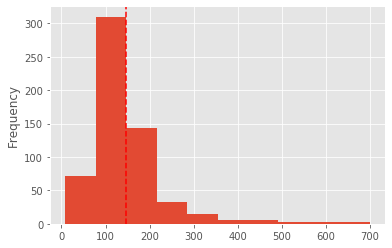

In [26]:
train['LoanAmount'].plot("hist")
plt.axvline(x = train['LoanAmount'].mean(), color='r', linestyle='--')
plt.show()

In [27]:
train['LoanAmount'].fillna(train['LoanAmount'].mean(), inplace=True)
test['LoanAmount'].fillna(test['LoanAmount'].mean(), inplace=True)

In [28]:
# Loan Term column is the number of days for the loan. So here we can not use mean value as mean value probably gives us 
# decimal values and days are obvously not in decimals. So here also lets see what is the most common value.
train.Loan_Amount_Term.value_counts()

360.0    512
180.0     44
480.0     15
300.0     13
84.0       4
240.0      4
120.0      3
36.0       2
60.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64

In [29]:
# We can see 85% cases term value is 360. So we will replace it with this only
train.Loan_Amount_Term.fillna(train.Loan_Amount_Term.value_counts().idxmax(), inplace=True)
test.Loan_Amount_Term.fillna(test.Loan_Amount_Term.value_counts().idxmax(), inplace=True)

In [30]:
train['Credit_History'].value_counts()

1.0    475
0.0     89
Name: Credit_History, dtype: int64

In [31]:
##Since the credit history has got two values (0) and 1 which implies that there are 
## 89 people who dont have credit history but most of them have the credit history.
train.Credit_History.fillna(train.Credit_History.value_counts().idxmax(), inplace=True)
test.Credit_History.fillna(test.Credit_History.value_counts().idxmax(), inplace=True)

In [32]:
train.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [33]:
test.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64

### Treating Outliers

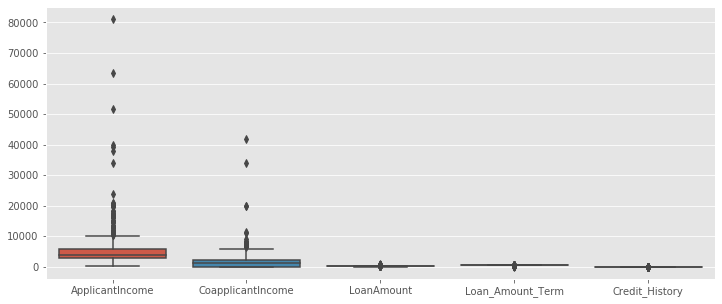

In [34]:
plt.figure(figsize=(12,5))
sns.boxplot(data = train)
plt.show()

There are outliers in the train dataset.

In [35]:
x = train.describe()
x

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,614.000000,614.000000,614.000000
mean,5403.459283,1621.245798,146.412162,342.410423,0.855049
std,6109.041673,2926.248369,84.037468,64.428629,0.352339
min,150.000000,0.000000,9.000000,12.000000,0.000000
25%,2877.500000,0.000000,100.250000,360.000000,1.000000
50%,3812.500000,1188.500000,129.000000,360.000000,1.000000
75%,5795.000000,2297.250000,164.750000,360.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.000000,1.000000


In [36]:
num_features=train.select_dtypes(include='number').columns
num_features

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History'],
      dtype='object')

In [37]:
for i in num_features:
    q1 = x.loc['25%', i]
    q3 = x.loc['75%', i]
    iqr = q3-q1
    uppl = q3+ 1.5*iqr
    lowl = q1- 1.5*iqr
    train[i] = train[i].apply(lambda x: uppl if x>uppl else x)
    train[i] = train[i].apply(lambda x: lowl if x<lowl else x)

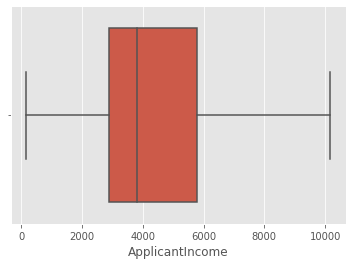

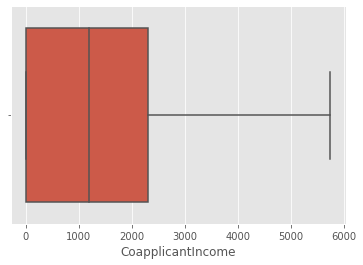

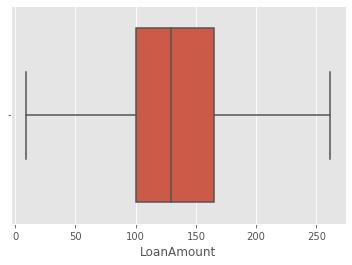

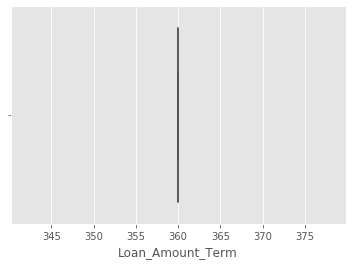

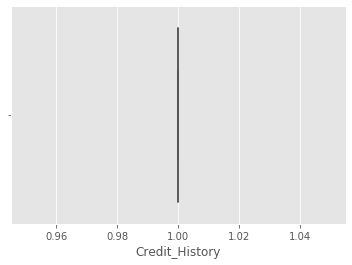

In [38]:
for i in num_features:
    sns.boxplot(train[i])
    plt.show()

- Outliers have been removed.

In [39]:
y = test.describe()
y

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,367.000000,367.000000,367.000000,367.000000,367.000000
mean,4805.599455,1569.577657,136.132597,342.822888,0.839237
std,4910.685399,2334.232099,60.946040,64.658402,0.367814
min,0.000000,0.000000,28.000000,6.000000,0.000000
25%,2864.000000,0.000000,101.000000,360.000000,1.000000
50%,3786.000000,1025.000000,126.000000,360.000000,1.000000
75%,5060.000000,2430.500000,157.500000,360.000000,1.000000
max,72529.000000,24000.000000,550.000000,480.000000,1.000000


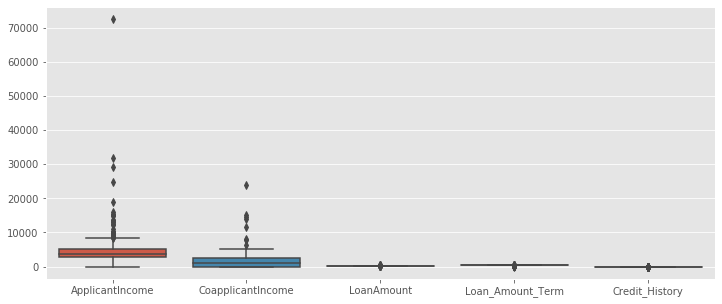

In [40]:
plt.figure(figsize=(12,5))
sns.boxplot(data = test)
plt.show()

In [41]:
for i in num_features:
    q1 = y.loc['25%', i]
    q3 = y.loc['75%', i]
    iqr = q3-q1
    uppl = q3+ 1.5*iqr
    lowl = q1- 1.5*iqr
    test[i] = test[i].apply(lambda x: uppl if x>uppl else x)
    test[i] = test[i].apply(lambda x: lowl if x<lowl else x)

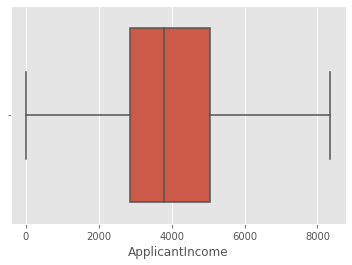

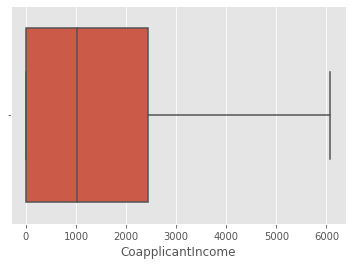

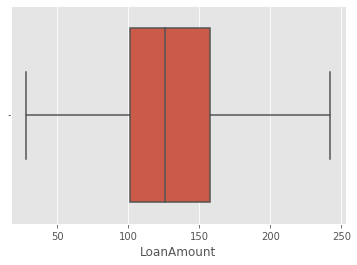

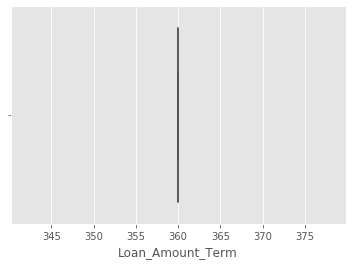

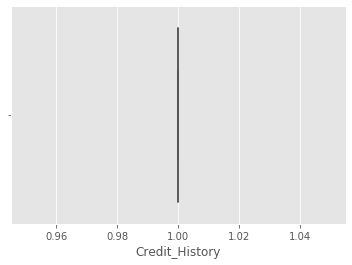

In [42]:
for i in num_features:
    sns.boxplot(test[i])
    plt.show()

### Exploratory Data Analysis

#### Univariate Analysis

In [43]:
train

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849.0,0.0,146.412162,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583.0,1508.0,128.000000,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000.0,0.0,66.000000,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583.0,2358.0,120.000000,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000.0,0.0,141.000000,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900.0,0.0,71.000000,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106.0,0.0,40.000000,360.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072.0,240.0,253.000000,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583.0,0.0,187.000000,360.0,1.0,Urban,Y


In [44]:
x.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,8.000000,8.000000,8.000000,8.000000,8.000000
mean,13220.187620,6289.280521,243.431204,324.104882,77.400923
std,27480.194323,14332.564054,260.587094,199.063576,216.819092
min,150.000000,0.000000,9.000000,12.000000,0.000000
25%,2311.625000,460.500000,96.196867,272.914975,0.729371
50%,4607.979642,1404.872899,137.706081,360.000000,1.000000
75%,5873.510418,2454.499592,277.062500,390.000000,1.000000
max,81000.000000,41667.000000,700.000000,614.000000,614.000000


#### Applicant Income

C:\Users\satyam\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='hist')` instead of `Series.plot('hist',)`.
  """Entry point for launching an IPython kernel.


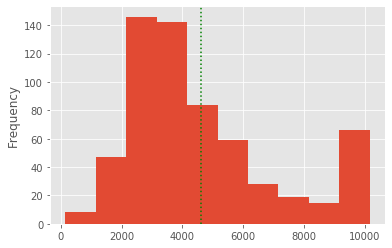

In [45]:
train['ApplicantIncome'].plot("hist")
plt.axvline(x = train.ApplicantIncome.mean(), color = 'g', linestyle=':')
plt.show()

- Most of Applicant income lies in the range of 2500-4000 and the average applicant income is 4607.

#### Coapplicant Income

C:\Users\satyam\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='hist')` instead of `Series.plot('hist',)`.
  """Entry point for launching an IPython kernel.


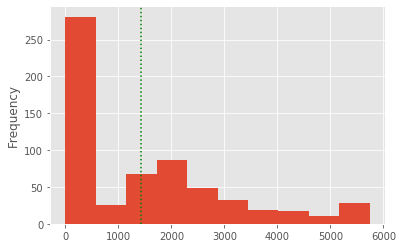

In [46]:
train.CoapplicantIncome.plot("hist")
plt.axvline(x = train.CoapplicantIncome.mean(), color = 'g', linestyle=':')
plt.show()

In [47]:
train['CoapplicantIncome'].value_counts().idxmax()

0.0

- Most of the Coapplicant have 0 income and the average coapplicant income is 1404.

### Bivariate Analysis

#### Loan status by gender

Text(0.5, 1.0, 'Distribution of loan status by Gender')

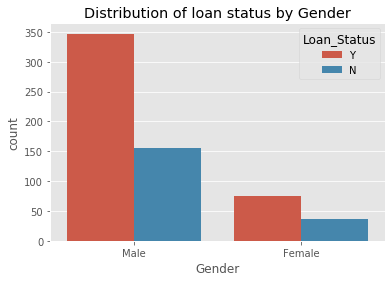

In [48]:
sns.countplot(x=train.Gender, hue=train.Loan_Status)
plt.title("Distribution of loan status by Gender")

- Most of the male applicants are eligible for the loan.

#### Loan Status by Marital Status

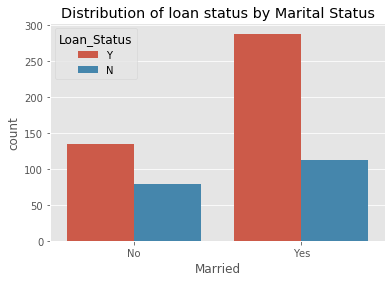

In [49]:
sns.countplot(x=train.Married, hue=train.Loan_Status)
plt.title("Distribution of loan status by Marital Status")
plt.show()

Most of the Married applicants are eligible for loan.

#### Loan Status by Education

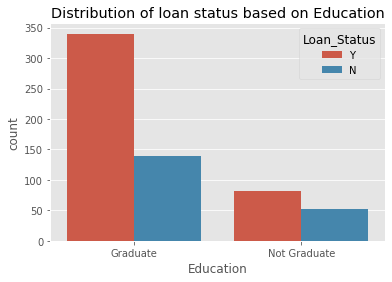

In [50]:
sns.countplot(x=train.Education, hue=train.Loan_Status)
plt.title("Distribution of loan status based on Education")
plt.show()

Most of the graduate applicants are eligible for loan.

### Loan Status by Self-Employement

Text(0.5, 1.0, 'Distribution of Loan Status Variable by Self Employment status')

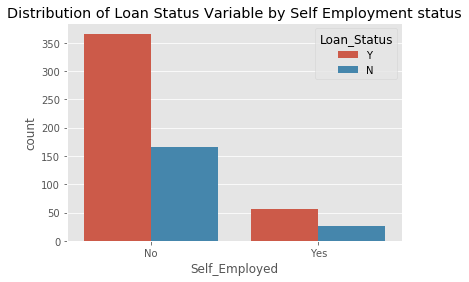

In [51]:
sns.countplot(x=train.Self_Employed,hue=train.Loan_Status)
plt.title("Distribution of Loan Status Variable by Self Employment status")

If the applicant is self employed there is a low chance of loan approval.

#### Loan Status by Self property_Area

Text(0.5, 1.0, 'Distribution of Loan Status Variable by Self property_Area')

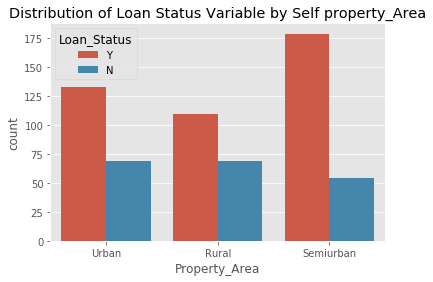

In [52]:
sns.countplot(x=train.Property_Area,hue=train.Loan_Status)
plt.title("Distribution of Loan Status Variable by Self property_Area")

Applicant staying in Semiurban area have high chance of loan approval comapred to Urban and Rural areas.

#### Loan Status by Credit_History

Text(0.5, 1.0, 'Distribution of Loan Status Variable by Self property_Area')

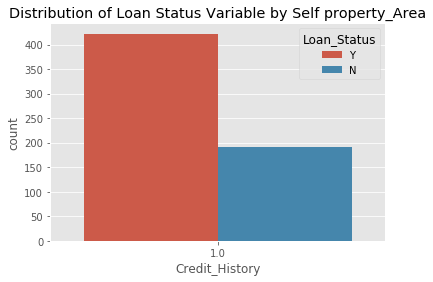

In [53]:
sns.countplot(x=train.Credit_History,hue=train.Loan_Status)
plt.title("Distribution of Loan Status Variable by Self property_Area")

If the applicant have self property, there's a high chance of the loan approval.

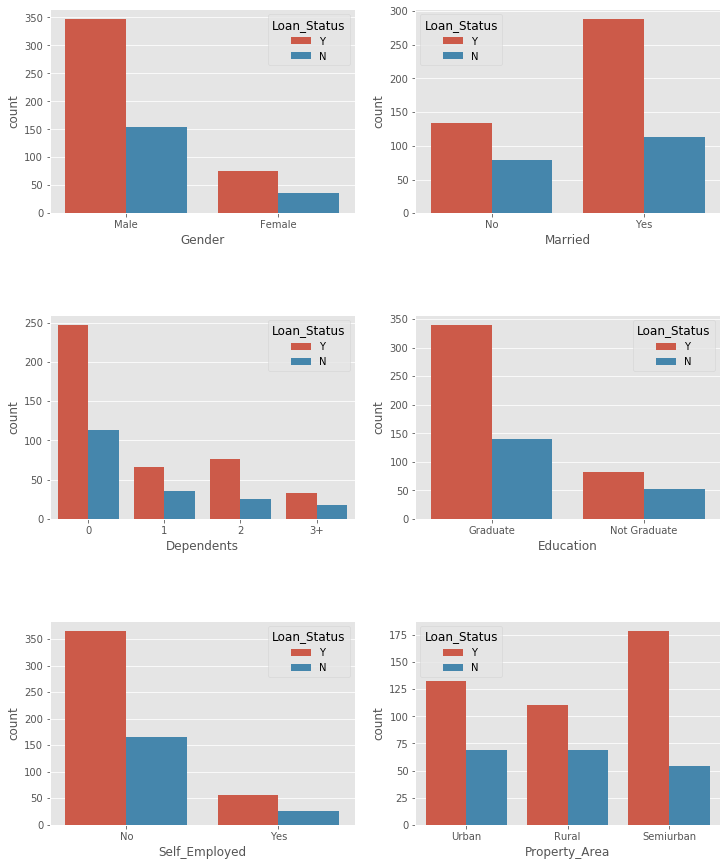

In [54]:
categorical_columns=['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Property_Area']
fig,axes = plt.subplots(3,2,figsize=(12,15))
for idx,cat_col in enumerate(categorical_columns):
    row,col = idx//2,idx%2
    sns.countplot(x=cat_col,data=train,hue='Loan_Status',ax=axes[row,col])


plt.subplots_adjust(hspace=0.5)


- Applicants who have no dependents have high chances of loan approval.
- Graduates have high chances of loan approval.
- Loan Approval Status: About 2/3rd of applicants have been granted loan.
- Sex: There are more Men than Women (approx. 3x)
- Martial Status: 2/3rd of the population in the dataset is Marred; Married applicants are more likely to be granted loans.
- Dependents: Majority of the population have zero dependents and are also likely to accepted for loan.
- Education: About 5/6th of the population is Graduate and graduates have higher propotion of loan approval
- Employment: 5/6th of population is not self employed.
- Property Area: More applicants from Semi-urban and also likely to be granted loans.
- Applicant with credit history are far more likely to be accepted.

### Encoding Categorical features

In [55]:
df = train.copy()
df.drop('Loan_ID', axis=1, inplace=True)

In [56]:
df_dummy = pd.get_dummies(data=df, drop_first=True)
df_dummy

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y
0,5849.0,0.0,146.412162,360.0,1.0,1,0,0,0,0,0,0,0,1,1
1,4583.0,1508.0,128.000000,360.0,1.0,1,1,1,0,0,0,0,0,0,0
2,3000.0,0.0,66.000000,360.0,1.0,1,1,0,0,0,0,1,0,1,1
3,2583.0,2358.0,120.000000,360.0,1.0,1,1,0,0,0,1,0,0,1,1
4,6000.0,0.0,141.000000,360.0,1.0,1,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,2900.0,0.0,71.000000,360.0,1.0,0,0,0,0,0,0,0,0,0,1
610,4106.0,0.0,40.000000,360.0,1.0,1,1,0,0,1,0,0,0,0,1
611,8072.0,240.0,253.000000,360.0,1.0,1,1,1,0,0,0,0,0,1,1
612,7583.0,0.0,187.000000,360.0,1.0,1,1,0,1,0,0,0,0,1,1


In [57]:
X = df_dummy.drop('Loan_Status_Y', axis=1)
y = df_dummy.Loan_Status_Y

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=3)

In [66]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV,KFold,StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

C:\Users\satyam\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\satyam\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


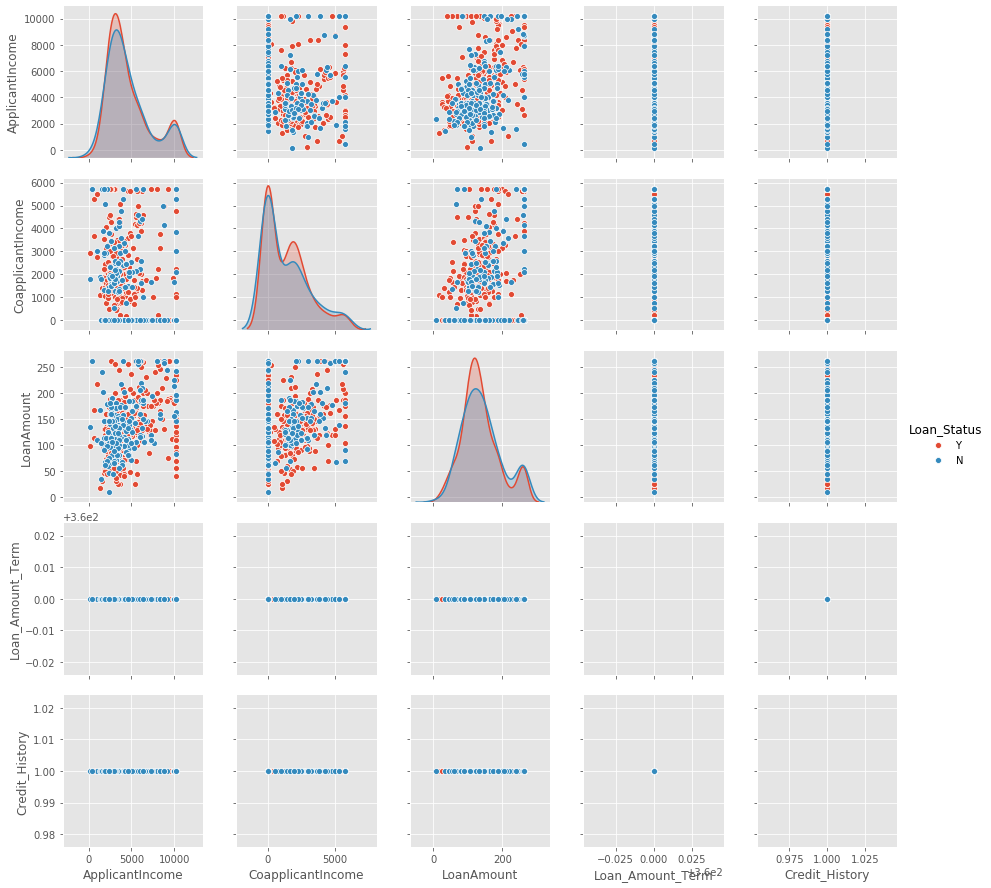

In [67]:
sns.pairplot(data = train, hue='Loan_Status')
plt.show()

From the above plot, we can see a lot of points overlapping hence we'll build a Decision Tree model or Knn model.

In [69]:
from sklearn.preprocessing import MinMaxScaler

In [70]:
scaler = MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)

X.shape, y.shape

((614, 14), (614,))

### Model2: Decision Tree Classifier

In [73]:
from sklearn.model_selection import cross_val_score

tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train,y_train)
y_pred = tree_clf.predict(X_train)
print("Training Data Set Accuracy: ", accuracy_score(y_train,y_pred))
print("Training Data F1 Score ", f1_score(y_train,y_pred))

print("Validation Mean F1 Score: ",cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='f1_macro').mean())
print("Validation Mean Accuracy: ",cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='accuracy').mean())

Training Data Set Accuracy:  1.0
Training Data F1 Score  1.0
Validation Mean F1 Score:  0.543191695044625
Validation Mean Accuracy:  0.6090343791374719


The model is overfitting as Training Accuracy > Test Accuracy. Hence hypertuing the tree parameters.

In [ ]:
tr=DecisionTreeClassifier()
kf=KFold(n_splits=3,random_state=3)
parameters={'criterion':('gini', 'entropy'), 
              'min_samples_split':[2,3,4,5], 
              'max_depth':[x for x in range(1,10)],
            
              'class_weight':('balanced', None),
              'presort':(False,True)}
gsearch=GridSearchCV(tr,param_grid=parameters, cv=kf)

In [88]:
tr = DecisionTreeClassifier()
kf = StratifiedKFold(n_splits=5,shuffle=False,random_state=0)
parameters={'criterion':('gini', 'entropy'),
           'min_samples_split':[2,3,4,5],
           'max_depth':[x for x in range(1, 10)],
           'class_weight':('balanced', None),
            'presort':(False,True)}
gsearch = GridSearchCV(tr, param_grid=parameters, cv=kf)

In [89]:
gsearch.fit(X_train, y_train)

C:\Users\satyam\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=False),
             error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'class_weight': ('balanced', None),
     

In [90]:
model = gsearch.best_estimator_
model

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [91]:
score = model.score(X_test, y_test)
score

0.7723577235772358

In [92]:
score = model.score(X_test, y_test)
score

0.7723577235772358

In [93]:
y_pred=model.predict(X_test)
accuracy_score(y_test,y_pred)

0.7723577235772358

In [94]:
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.7723577235772358

In [95]:
y_train_pred=model.predict(X_train)
print("Test Accuracy: ",accuracy_score(y_test,y_pred))
print("Test F1 Score: ",f1_score(y_test,y_pred))
print("Train Accuracy: ",accuracy_score(y_train,y_train_pred))
print("Train F1 Score: ",f1_score(y_train,y_train_pred))

pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)


confusion_matrix(y_test, y_pred)

Test Accuracy:  0.7723577235772358
Test F1 Score:  0.8715596330275228
Train Accuracy:  0.6659877800407332
Train F1 Score:  0.7995110024449877


array([[ 0, 28],
       [ 0, 95]], dtype=int64)

In [87]:
y_train_pred = model.predict(X_train)
print("Test Accuracy: ",accuracy_score(y_test,y_pred))
print("Test F1 Score: ",f1_score(y_test,y_pred))
print("Train Accuracy: ",accuracy_score(y_train,y_train_pred))
print("Train F1 Score: ",f1_score(y_train,y_train_pred))

pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)


confusion_matrix(y_test, y_pred)

Test Accuracy:  0.7723577235772358
Test F1 Score:  0.8715596330275228
Train Accuracy:  0.6659877800407332
Train F1 Score:  0.7995110024449877


array([[ 0, 28],
       [ 0, 95]], dtype=int64)

In [96]:
from sklearn.metrics import confusion_matrix
tree_clf = DecisionTreeClassifier(max_depth=3,min_samples_leaf = 1)
tree_clf.fit(X_train,y_train)
y_pred = tree_clf.predict(X_test)
print("Test Accuracy: ",accuracy_score(y_test,y_pred))
print("Test F1 Score: ",f1_score(y_test,y_pred))
print("Confusion Matrix on Test Data")
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Test Accuracy:  0.7317073170731707
Test F1 Score:  0.8436018957345971
Confusion Matrix on Test Data


Predicted,0,1,All
True,,,
0,1,27,28
1,6,89,95
All,7,116,123


C:\Users\satyam\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\satyam\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\satyam\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\satyam\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\satyam\Anaconda3\lib\site-packages\sklearn\metr

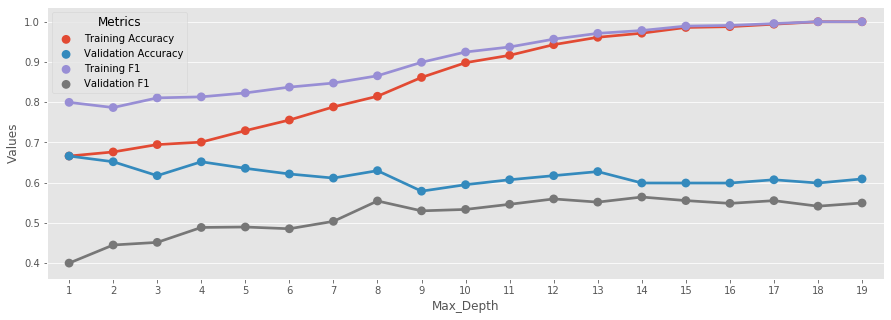

In [97]:
training_accuracy = []
val_accuracy = []
training_f1 = []
val_f1 = []
tree_depths = []

for depth in range(1,20):
    tree_clf = DecisionTreeClassifier(max_depth=depth)
    tree_clf.fit(X_train,y_train)
    y_training_pred = tree_clf.predict(X_train)

    training_acc = accuracy_score(y_train,y_training_pred)
    train_f1 = f1_score(y_train,y_training_pred)
    val_mean_f1 = cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='f1_macro').mean()
    val_mean_accuracy = cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='accuracy').mean()
    
    training_accuracy.append(training_acc)
    val_accuracy.append(val_mean_accuracy)
    training_f1.append(train_f1)
    val_f1.append(val_mean_f1)
    tree_depths.append(depth)
    

Tuning_Max_depth = {"Training Accuracy": training_accuracy, "Validation Accuracy": val_accuracy, "Training F1": training_f1, "Validation F1":val_f1, "Max_Depth": tree_depths }
Tuning_Max_depth_df = pd.DataFrame.from_dict(Tuning_Max_depth)

plot_df = Tuning_Max_depth_df.melt('Max_Depth',var_name='Metrics',value_name="Values")
fig,ax = plt.subplots(figsize=(15,5))
sns.pointplot(x="Max_Depth", y="Values",hue="Metrics", data=plot_df,ax=ax)

### min_samples_leaf hypertuning

C:\Users\satyam\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\satyam\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\satyam\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\satyam\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\satyam\Anaconda3\lib\site-packages\sklearn\metr

C:\Users\satyam\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\satyam\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\satyam\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\satyam\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\satyam\Anaconda3\lib\site-packages\sklearn\metr

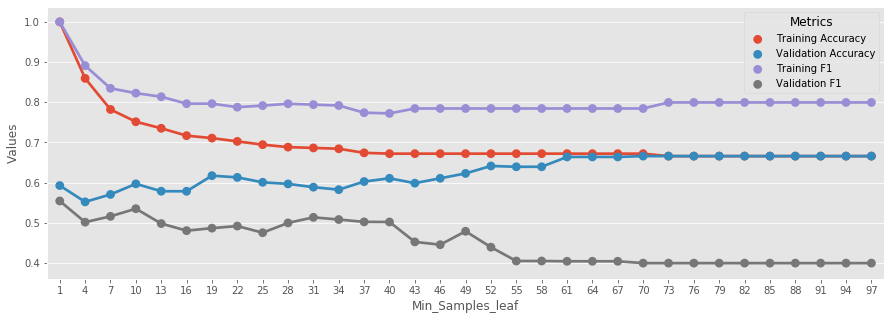

In [98]:
training_accuracy = []
val_accuracy = []
training_f1 = []
val_f1 = []
min_samples_leaf = []

for samples_leaf in range(1,100,3):
    tree_clf = DecisionTreeClassifier(min_samples_leaf=samples_leaf)
    tree_clf.fit(X_train,y_train)
    y_training_pred = tree_clf.predict(X_train)

    training_acc = accuracy_score(y_train,y_training_pred)
    train_f1 = f1_score(y_train,y_training_pred)
    val_mean_f1 = cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='f1_macro').mean()
    val_mean_accuracy = cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='accuracy').mean()
    
    training_accuracy.append(training_acc)
    val_accuracy.append(val_mean_accuracy)
    training_f1.append(train_f1)
    val_f1.append(val_mean_f1)
    min_samples_leaf.append(samples_leaf)
    

Tuning_min_samples_leaf = {"Training Accuracy": training_accuracy, "Validation Accuracy": val_accuracy, "Training F1": training_f1, "Validation F1":val_f1,"Min_Samples_leaf": min_samples_leaf  }
Tuning_min_samples_leaf_df = pd.DataFrame.from_dict(Tuning_min_samples_leaf)

plot_df = Tuning_min_samples_leaf_df.melt('Min_Samples_leaf',var_name='Metrics',value_name="Values")
fig,ax = plt.subplots(figsize=(15,5))
sns.pointplot(x="Min_Samples_leaf", y="Values",hue="Metrics", data=plot_df,ax=ax)

### Random Forest Classifier model with default parameters

In [74]:
from sklearn.ensemble import RandomForestClassifier

# instantiate the classifier 
rfc = RandomForestClassifier(random_state=0)


# fit the model
rfc.fit(X_train, y_train)


# Predict the Test set results
y_pred = rfc.predict(X_test)


# Check accuracy score 
from sklearn.metrics import accuracy_score
print('Model accuracy score with 10 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with 10 decision-trees : 0.7073


C:\Users\satyam\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### Random Forest Classifier model with 100 Decision Trees

In [79]:
# instantiate the classifier with n_estimators = 100
rfc_100 = RandomForestClassifier(n_estimators=100, random_state=0)

# fit the model to the training set
rfc_100.fit(X_train, y_train)

# Predict on the test set results
y_pred_100 = rfc_100.predict(X_test)

# Check accuracy score 
print('Model accuracy score with 100 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred_100)))

Model accuracy score with 100 decision-trees : 0.6992


In [102]:
# from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_100)

print('Confusion matrix\n\n', cm)

Confusion matrix

 [[ 6 22]
 [15 80]]


In [103]:
print("Test Accuracy: ",accuracy_score(y_test,y_pred_100))
print("Test F1 Score: ",f1_score(y_test,y_pred_100))
print("Confusion Matrix on Test Data")
pd.crosstab(y_test, y_pred_100, rownames=['True'], colnames=['Predicted'], margins=True)

Test Accuracy:  0.6991869918699187
Test F1 Score:  0.8121827411167514
Confusion Matrix on Test Data


Predicted,0,1,All
True,,,
0,6,22,28
1,15,80,95
All,21,102,123


### Model: XG Boost

In [109]:
def cross_val(X_train, y_train, model):
    # Applying k-Fold Cross Validation
    from sklearn.model_selection import cross_val_score
    accuracies = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 5)
    return accuracies.mean()

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    model_cross = cross_val(X_train, y_train, model)
    
    # Return the performance metric
    return model_cross

In [110]:
# # Gradiente Boosting Classification
from xgboost import XGBClassifier
gb = XGBClassifier()
gb_cross = fit_and_evaluate(gb)

print('Gradiente Boosting Classification Performance on the test set: Cross Validation Score = %0.4f' % gb_cross)

Gradiente Boosting Classification Performance on the test set: Cross Validation Score = 0.6111


### Model: KNN

The optimal number of neighbors is 40


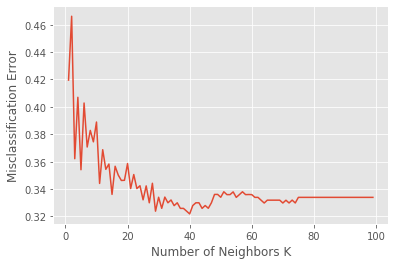

0.7560975609756098
              precision    recall  f1-score   support

           0       0.25      0.04      0.06        28
           1       0.77      0.97      0.86        95

    accuracy                           0.76       123
   macro avg       0.51      0.50      0.46       123
weighted avg       0.65      0.76      0.68       123



In [112]:
from sklearn.neighbors import KNeighborsClassifier

#Hyperparameter Tuning for K
K_list=list(range(1,100))

#create empty list
cv_scores=[]

#perform K search
for k in K_list:
    knn=KNeighborsClassifier(n_neighbors=k)
    scores=cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    

#Plotting misclassification error

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = K_list[MSE.index(min(MSE))]
print ("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.plot(K_list, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

#Look how the number of neighbors drastically increases the MSE rate

# Try KNN to see how well it predicts fraud on the undersampled dataset
knn=KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train, y_train)
y_knn_predict=knn.predict(X_test)
print (accuracy_score(y_test, y_knn_predict))
print(classification_report(y_test, y_knn_predict))

In [113]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
455,1,1
132,1,1
244,1,1
53,0,1
264,1,1
...,...,...
544,1,1
129,0,1
360,0,1
446,1,1
